# AR Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from pandas.plotting import register_matplotlib_converters
from datetime import timedelta, datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()

In [2]:
# Ice cream production data
production_ice_cream = pd.read_csv('./data/ice_cream.csv', parse_dates=[0],  date_format="%Y-%m-%d", index_col=[0])

In [3]:
production_ice_cream = production_ice_cream.squeeze()

In [4]:
production_ice_cream.rename('production', inplace=True)

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: production, Length: 577, dtype: float64

In [5]:
# Extra cleaning by infering frequency that the data is the start of each month
production_ice_cream = production_ice_cream.asfreq(pd.infer_freq(production_ice_cream.index))

In [6]:
# Get only data from 2010 onwards
start_date = pd.to_datetime('2010-01-01')
production_ice_cream = production_ice_cream[start_date:]

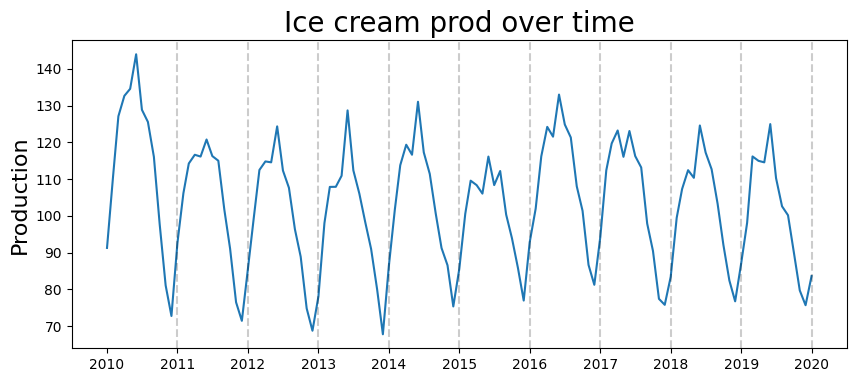

In [7]:
plt.figure(figsize=(10, 4))
plt.plot(production_ice_cream)
plt.title("Ice cream prod over time", fontsize=20)
plt.ylabel("Production", fontsize=16)
for year in range(2011, 2021):
    plt.axvline(pd.to_datetime(f"{year}-01-01"), color='k', linestyle='--', alpha=0.2)


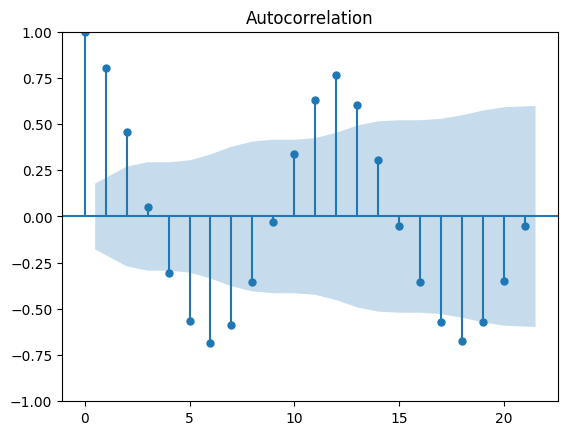

In [8]:
acf_plot = plot_acf(production_ice_cream)

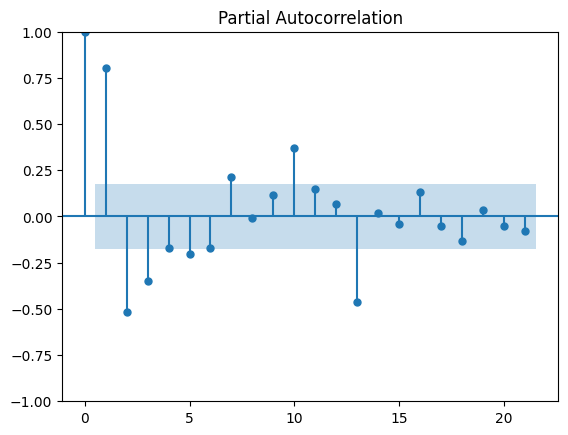

In [9]:
pacf_plot = plot_pacf(production_ice_cream)

Based on the PACF, we should start an AR model with the lags 1, 2 ,3 

In [10]:
# Get training and testing sets
train_end = datetime(2018, 12, 1)
test_end = datetime(2019, 12, 1)

train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[train_end + timedelta(days=1):test_end]


In [11]:
# Fit AR model
model = ARIMA(train_data, order=(3, 0, 0)) # Set only the AR portion

In [12]:
start_time = time.time()
model_fit = model.fit()
end_time = time.time()
print(f"Model took {end_time - start_time} to fit the data")

Model took 0.023430347442626953 to fit the data


In [13]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  108
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -374.085
Date:                Mon, 02 Sep 2024   AIC                            758.170
Time:                        16:23:48   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5743      2.169     47.761      0.000      99.324     107.825
ar.L1          1.0469      0.102     10.256      0.000       0.847       1.247
ar.L2         -0.0523      0.175     -0.298      0.7

From the summary, we look at the P values (P>|z|), which shows us statistical significance. If the values are below 0.05, they are statistically significant. Therefore, looking at the summary, we see that L2 is not significant to the model and can be excluded.

In [14]:
# Get start/end times for prediction
pred_start = test_data.index[0]
pred_end = test_data.index[-1]

In [15]:
# Predict and get residuals
preds = model_fit.predict(start=pred_start, end=pred_end)
residuals = test_data - preds

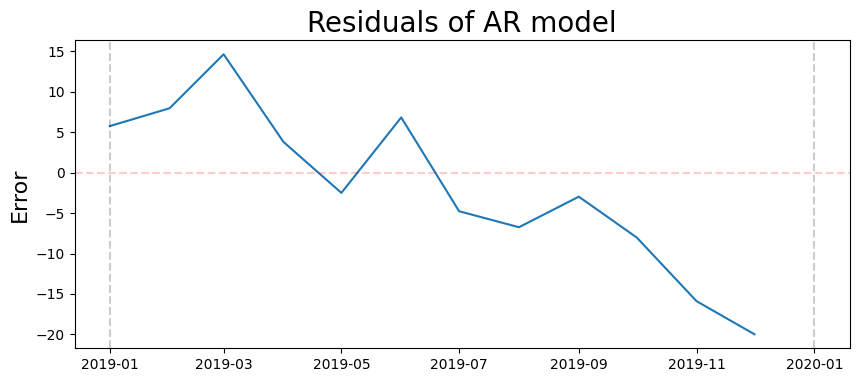

In [16]:
# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title("Residuals of AR model", fontsize=20)
plt.ylabel("Error", fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)
for year in range(2019, 2021):
    plt.axvline(pd.to_datetime(f"{year}-01-01"), color='k', linestyle='--', alpha=0.2)

We see a pattern in the residuals, which is typically not what we want. Indicates that there are some dynamics in the data we couldn't capture with this model

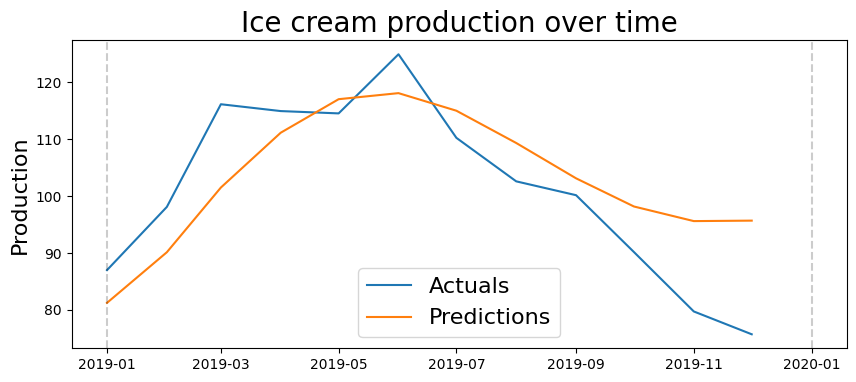

In [17]:
# Plot predictions vs actulas

plt.figure(figsize=(10, 4))

plt.plot(test_data)
plt.plot(preds)

plt.legend(('Actuals', 'Predictions'), fontsize=16)

plt.title("Ice cream production over time", fontsize=20)
plt.ylabel("Production", fontsize=16)

for year in range(2019, 2021):
    plt.axvline(pd.to_datetime(f"{year}-01-01"), color='k', linestyle='--', alpha=0.2)

As we know with `extrapolation` and forecasting, the errors increases the further we try to predict. Thus seeing the tail end of the prediction being quite off

In [18]:
print("Mean Absolute Error:", round(np.mean(abs(residuals/test_data)), 4))

Mean Absolute Error: 0.0895


In [19]:
print("Root Mean Squared Error:", np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 9.884158745573648


## What if we increase the complexity of the model?

AR(3) -> AR(7)

In [20]:
# Fit AR model
model = ARIMA(train_data, order=(7, 0, 0)) # Set only the AR portion

In [21]:
start_time = time.time()
model_fit = model.fit()
end_time = time.time()
print(f"Model took {end_time - start_time} to fit the data")

Model took 0.04650521278381348 to fit the data


In [70]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  108
Model:                 ARIMA(7, 0, 0)   Log Likelihood                -361.526
Date:                Mon, 02 Sep 2024   AIC                            741.051
Time:                        13:12:12   BIC                            765.191
Sample:                    01-01-2010   HQIC                           750.839
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.6216      1.339     77.406      0.000     100.998     106.245
ar.L1          0.9497      0.097      9.837      0.000       0.760       1.139
ar.L2         -0.0964      0.131     -0.735      0.4

In [71]:
# Predict and get residuals
preds = model_fit.predict(start=pred_start, end=pred_end)
residuals = test_data - preds

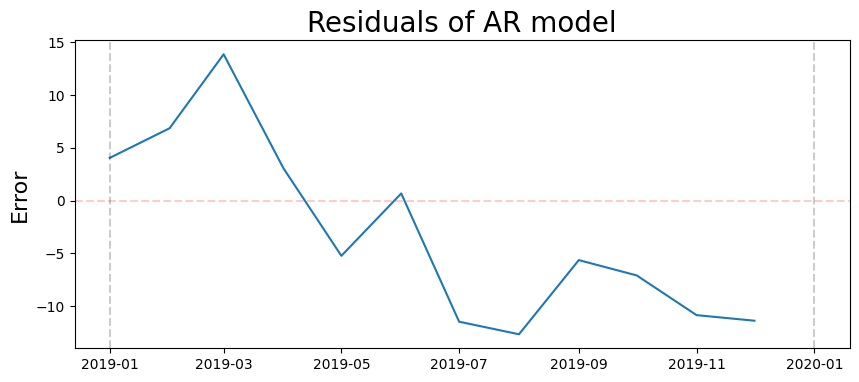

In [72]:
# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title("Residuals of AR model", fontsize=20)
plt.ylabel("Error", fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)
for year in range(2019, 2021):
    plt.axvline(pd.to_datetime(f"{year}-01-01"), color='k', linestyle='--', alpha=0.2)

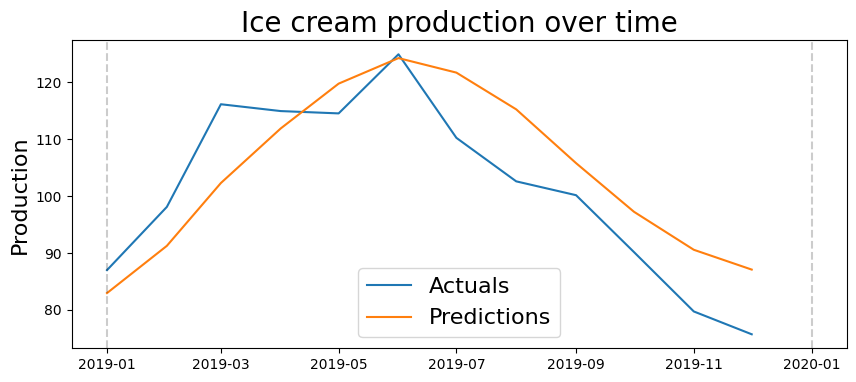

In [73]:
# Plot predictions vs actulas

plt.figure(figsize=(10, 4))

plt.plot(test_data)
plt.plot(preds)

plt.legend(('Actuals', 'Predictions'), fontsize=16)

plt.title("Ice cream production over time", fontsize=20)
plt.ylabel("Production", fontsize=16)

for year in range(2019, 2021):
    plt.axvline(pd.to_datetime(f"{year}-01-01"), color='k', linestyle='--', alpha=0.2)

In [74]:
print("Mean Absolute Error:", round(np.mean(abs(residuals/test_data)), 4))

Mean Absolute Error: 0.0802


In [75]:
print("Root Mean Squared Error:", np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 8.725440358152422


Here we see that the prediction is a bit closer the the actual values. Although looking at the error metrics, the model did not improve much despite the added complexity. In this case, the amount of complexity added to the model is most likely not worth the performance trade off.